In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import random
from tqdm import tqdm
from PIL import Image
from sklearn.utils import class_weight
import tensorflow_hub as hub

In [3]:
#[1,0]是good [0,1]是bad
class_names = ['good','bad']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

def load_data():
    datasets = ['train', 'test']#資料夾
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv讀照片，顏色莫認為BGR，需轉為RGB，錯誤表示黑白或已轉
                image = cv2.resize(image, IMAGE_SIZE)  
                #image = Image.convert("L")
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|██████████| 6716/6716 [01:18<00:00, 85.28it/s]


Loading test


100%|██████████| 2385/2385 [00:26<00:00, 89.19it/s]


In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 假设是一个二分类问题
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
422/422 [==============================] - 666s 2s/step - loss: 0.1780 - accuracy: 0.9320
Epoch 2/10
422/422 [==============================] - 648s 2s/step - loss: 0.0812 - accuracy: 0.9715
Epoch 3/10
422/422 [==============================] - 651s 2s/step - loss: 0.0453 - accuracy: 0.9832
Epoch 4/10
422/422 [==============================] - 646s 2s/step - loss: 0.0426 - accuracy: 0.9849
Epoch 5/10
422/422 [==============================] - 650s 2s/step - loss: 0.0370 - accuracy: 0.9877
Epoch 6/10
422/422 [==============================] - 658s 2s/step - loss: 0.0360 - accuracy: 0.9872
Epoch 7/10
422/422 [==============================] - 651s 2s/step - loss: 0.0300 - accuracy: 0.9905
Epoch 8/10
422/422 [==============================] - 645s 2s/step - loss: 0.0313 - accuracy: 0.9892
Epoch 9/10
422/422 [==============================] - 651s 2s/step - loss: 0.0302 - accuracy: 0.9904
Epoch 10/10
422/422 [==============================] - 652s 2s/step - loss: 0.0355 - accura

150/150 [==============================] - 50s 324ms/step


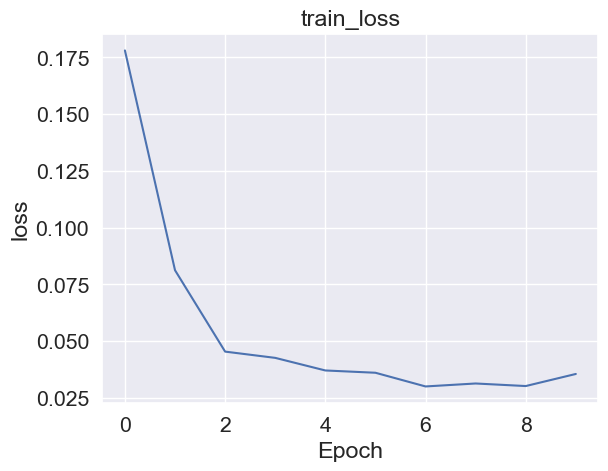

In [30]:
#模型概況
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])
#scores = model.evaluate(test_images,test_labels)
#print('test:',result[1])
#預測
predictions = model.predict(test_images)#Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

In [31]:
CM = confusion_matrix(test_labels,pred_labels)
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements =confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements
print(accuracy(CM))

0.7535475792988314


In [32]:
CM

array([[1532,  853],
       [ 328, 2079]], dtype=int64)

In [33]:
#model.save("EfficientNetB0.h5")

c:\ProgramData\Anaconda3\envs\AI_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


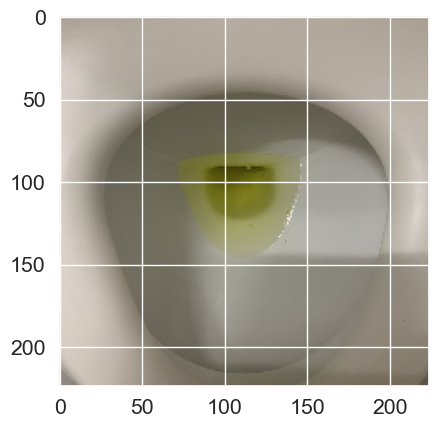

In [12]:
from tensorflow.keras.models import load_model
model = load_model('EfficientNetB0.h5')
IMAGE_path=r'D:\ColonPeace\Image\20230905\X220154582\bad_20230905065253467.jpg'
img=tf.keras.preprocessing.image.load_img(IMAGE_path,target_size=(224,224))
img=tf.keras.preprocessing.image.img_to_array(img)
#img=tf.image.rgb_to_grayscale(img) 
plt.imshow(img/255.)

In [14]:
logits = model(tf.expand_dims(img, 0), False)
print(logits)
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[:-1][:5].numpy()
print(idx)
predict=""
for i, id in enumerate(idx):
    print(f'top {i+1} ({pred[0][id]*100:.2f}%)：{id}')
    if id == 0: 
        predict = '上傳完成!\n\n依據目前的狀況，還需努力多喝水喔!' 
        break
    else: 
        predict = '上傳完成!\n\n恭喜清腸完成!辛苦大德了。' 
        break
print(predict)

tf.Tensor([[9.9987531e-01 1.2468117e-04]], shape=(1, 2), dtype=float32)
[1]
top 1 (26.90%)：1
上傳完成!

恭喜清腸完成!辛苦大德了。
